In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [2]:
from scale_aware_air_sea.cm26_utils import load_and_combine_cm26
import gcm_filters
import gcsfs
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# load example data
fs = gcsfs.GCSFileSystem()
ds = load_and_combine_cm26(fs)
ds

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [18]:
da = ds.isel(time=0)['surface_temp'].load()
da

<xarray.DataArray 'surface_temp' (yt_ocean: 2700, xt_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time      object 0181-01-01 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [66]:
# make filters
filter_scale = 50
transition_width = 1.5
# transition_width = np.pi
wet_mask = (~np.isnan(da)).astype(int)
dims = ['yt_ocean', 'xt_ocean']

gaussian_filter = gcm_filters.Filter(
    filter_scale=filter_scale,
    transition_width=transition_width,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)

taper_filter = gcm_filters.Filter(
    filter_scale=filter_scale*1.5,
    transition_width=transition_width,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.TAPER,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)

In [67]:
gaussian_filter

Filter(filter_scale=50, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=1.5, ndim=2, n_steps=56, grid_type=<GridType.REGULAR_WITH_LAND: 3>)

In [68]:
taper_filter

Filter(filter_scale=75.0, dx_min=1, filter_shape=<FilterShape.TAPER: 2>, transition_width=1.5, ndim=2, n_steps=627, grid_type=<GridType.REGULAR_WITH_LAND: 3>)

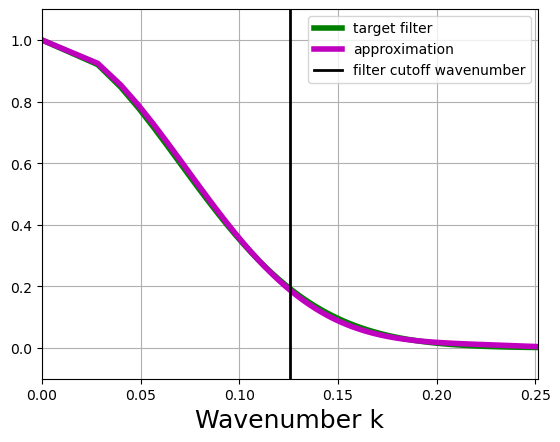

In [69]:
gaussian_filter.plot_shape()

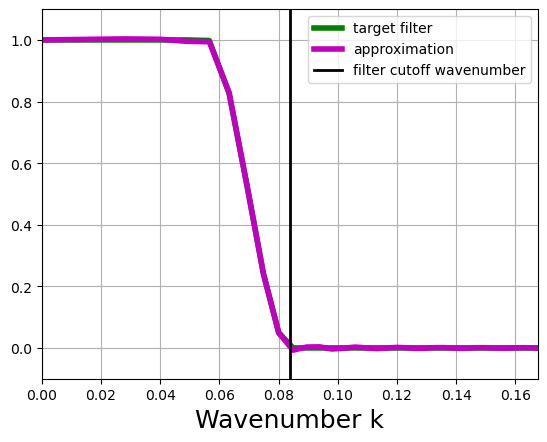

In [70]:
taper_filter.plot_shape()

# filter time baselines

for defaults (e.g. transition width=pi)
<!-- gaussian: 139 ms
taper: 333 ms -->

gaussian: 513 ms
taper: 1.74

In [71]:
%%time
# apply filter and test time
da_gaussian = gaussian_filter.apply(da, dims=dims).load()

CPU times: user 19.7 s, sys: 11.6 s, total: 31.3 s
Wall time: 31.3 s


In [72]:
%%time
# apply filter and test time
da_taper = taper_filter.apply(da, dims=dims).load()

CPU times: user 3min 39s, sys: 2min 9s, total: 5min 49s
Wall time: 5min 49s


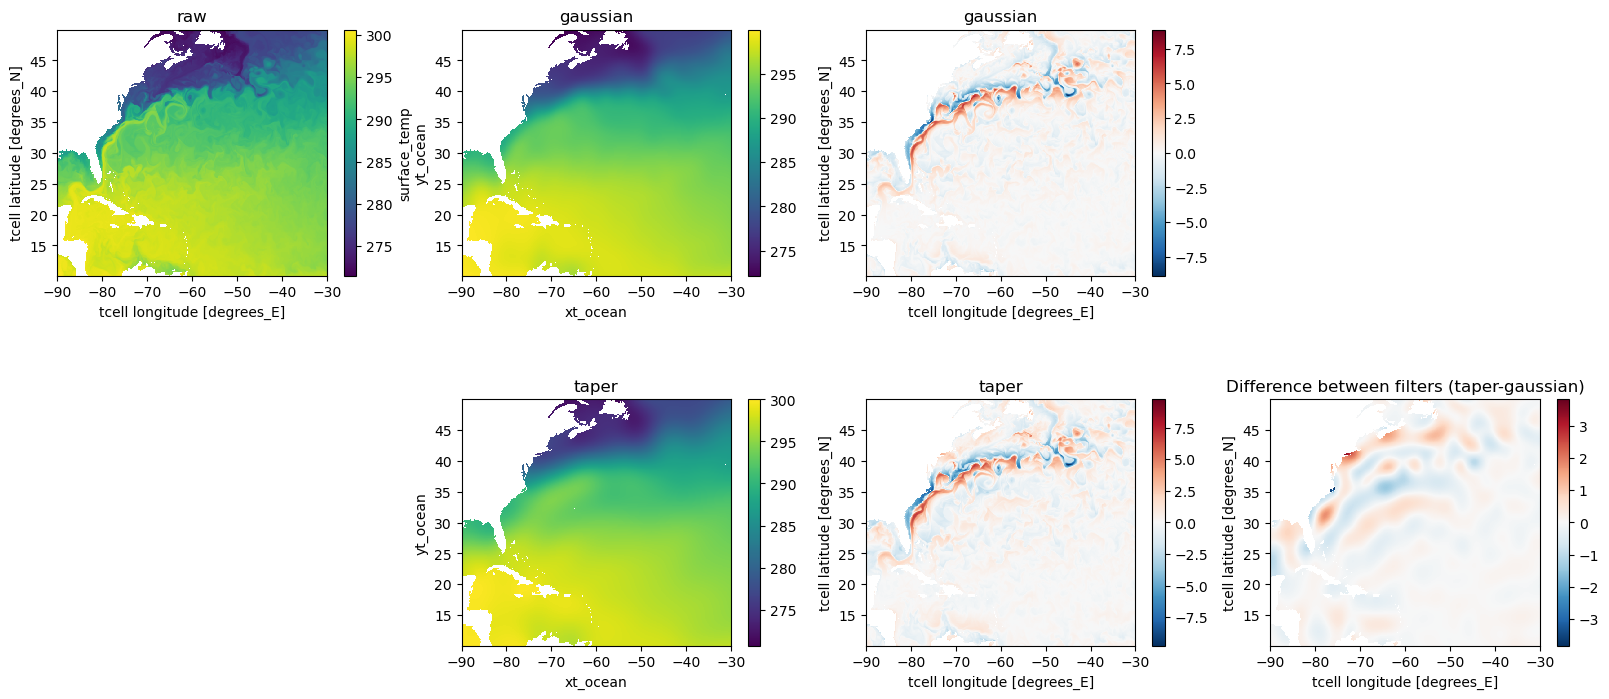

In [73]:
def sel_roi(da):
    return da.sel(xt_ocean=slice(-90, -30), yt_ocean=slice(10, 50))

plt.figure(figsize=[20,8])
plt.subplot(2,4,1)
sel_roi(da).plot()
plt.title('raw')
plt.subplot(2,4,2)
sel_roi(da_gaussian).plot()
plt.title('gaussian')
plt.subplot(2,4,3)
sel_roi(da-da_gaussian).plot()
plt.title('gaussian')

plt.subplot(2,4,6)
sel_roi(da_taper).plot()
plt.title('taper')
plt.subplot(2,4,7)
sel_roi(da-da_taper).plot()
plt.title('taper')
plt.subplot(2,4,8)
sel_roi((da-da_taper)-(da-da_gaussian)).plot()
plt.title('Difference between filters (taper-gaussian)')
plt.subplots_adjust(hspace=0.5)

## what do we get when we double filter? We want this to be as small as possible?

In [74]:
da_gaussian_double = gaussian_filter.apply(da_gaussian, dims=dims)
da_taper_double = taper_filter.apply(da_taper, dims=dims)

Text(0.5, 1.0, 'taper double filter anomaly')

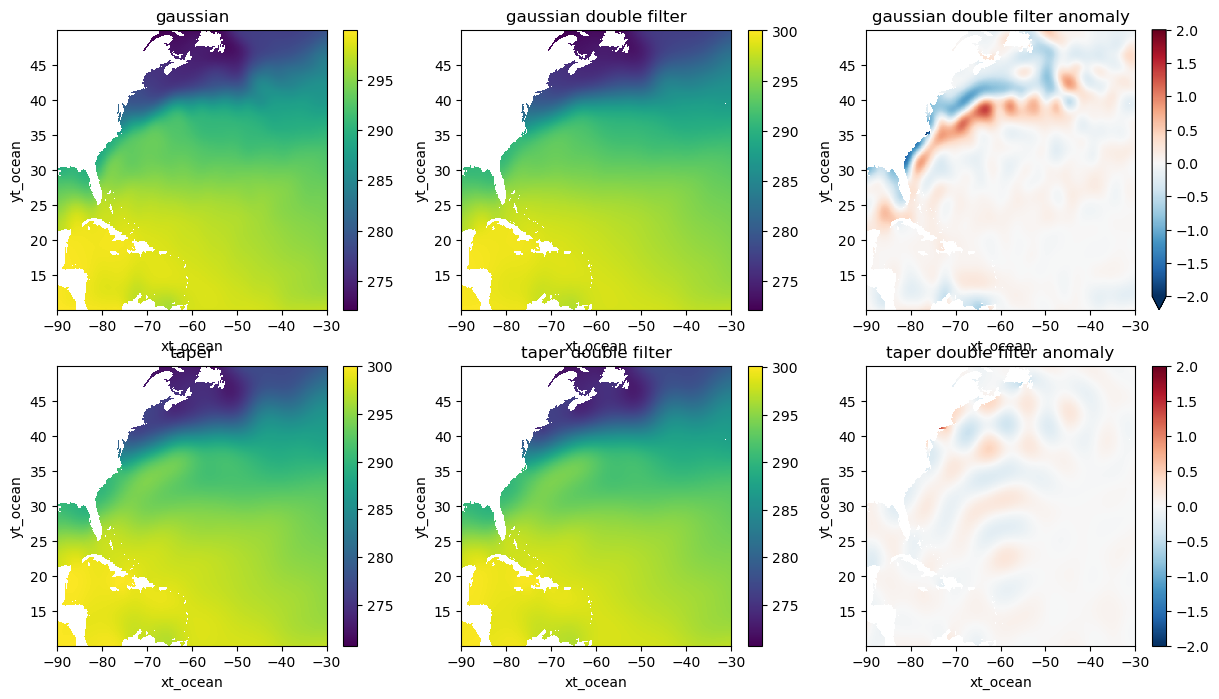

In [76]:
plt.figure(figsize=[20,8])
plt.subplot(2,4,1)
sel_roi(da_gaussian).plot()
plt.title('gaussian')
plt.subplot(2,4,2)
sel_roi(da_gaussian_double).plot()
plt.title('gaussian double filter')
plt.subplot(2,4,3)
sel_roi(da_gaussian-da_gaussian_double).plot(vmax=2)
plt.title('gaussian double filter anomaly')


plt.subplot(2,4,5)
sel_roi(da_taper).plot()
plt.title('taper')
plt.subplot(2,4,6)
sel_roi(da_taper_double).plot()
plt.title('taper double filter')
plt.subplot(2,4,7)
sel_roi(da_taper-da_taper_double).plot(vmax=2)
plt.title('taper double filter anomaly')